# AGN Data Challenge (Vincenzo Petrecca)

#### This notebook explains how to extract light curves from the *ForcedSourceTable* for each object in *Stripe82* and how to select Quasars using variability, colors and correlation among different bands

You can interact with the notebook by choosing the dimension of the random training set and commenting or un-commenting the lines into the plots to show different subsets. If you want to run the code on the whole dataset it could take more than an hour, so I would suggest to run an asynchronous job after un-commenting all the lines starting with *####*, so that all the relevant plots and tables are saved into files.

It takes ~ 7-8 minutes to run, with a random sample of 10.000 objects (default Sample). 

#### Short description

The first part of the notebook is just a simple explaination of how to select a random Sample of objects in *Stripe82* and extract arrays with the magnitudes and other useful parameters. Then, it separates the sources according to the *class* label and shows how to produce plots with the light curves and the thumbnails.

In the second part, I calculate the *Average Magnitude*, the *Standard Deviation* and the *Pearson Correlation Index* for all the object in the Sample using a 3-sigma clipping, homogenising the light curves (so they have the same number of non-null visits per band) and rejecting all the sources with less than 10 non-null visits.

The final part analyzes the distribution in Correlation of the different classes of objects and evaluates the efficiency of the selection of QSOs using variability, extension, color and correlation of light curves among different bands.

**WARNING:** you probably need to un-comment the following cell and install the requested libraries the first time you run this notebook in your environment.

In [1]:
# Install some library
# pip install tabulate
#### Uncomment this and all the cells starting with #### if you need to run the notebook asynchronously 
#pip install pyarrow

In [3]:
# Commonly used modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sn
import scipy.stats
import os, sys
import yaml
import csv
from astropy.time import Time
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

pd.set_option('display.max_columns', 999)

# Data challenge root data dir
data_dir = "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

In [4]:
!ls "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

ForcedSourceTable.parquet	 s82ObjectTable.parquet
ObjectTable.parquet		 s82SourceTable.parquet
ObjectTable_Blinded.parquet	 xmmlssMultiWavelengthTable.parquet
cutouts				 xmmlssObjectTable.parquet
s82MultiWavelengthTable.parquet


#### Load the *ForcedSource* table, containing light curves of Stripe82 from the SDSS

In [5]:
# It will take up to ~30 secs
fs_df = pd.read_parquet(os.path.join(data_dir, 'ForcedSourceTable.parquet'))
# Display the first three rows
fs_df.head(3)

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
0,1377887,52959.13,23.269028,0.442568,9007199422513169,1584.230835,759.312988,839.39703,1350.93301,0
1,1377887,54379.29,NaN,NaN,9007199397347585,-210.056396,1103.294067,-954.89032,1570.26164,0
2,1377887,53674.19,23.163357,0.562635,9007199397380353,1773.329224,1049.915405,1028.49530,1533.22740,0


In [6]:
# Group the forcedsource table by objectId
fs_gp = fs_df.groupby('objectId')

#### Load the *ObjectTable*, containing one entry for each object in the *extended-Stripe82*

In [7]:
# Load the object table
object_df = pd.read_parquet(os.path.join(data_dir, 'ObjectTable.parquet'))
object_df.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo

In [8]:
# Select the objects that have time domain data
lc_cols = [col for col in object_df.columns if 'Periodic' in col]
td_objects = object_df.dropna(subset=lc_cols, how='all').copy()
td_objects.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo

#### Extract arrays with the objectID, the class, the extendeness parameter and the standard colors for all the time domain objects

##### N.B. I will only focus on g-r-i bands light curves in my analysis.

In [9]:
# How many objects are in the table
total = td_objects.shape[0]
print('There are', total, 'time domain objects in Stripe 82')
# Extract arrays
indices = np.asarray(td_objects.index)
classes = np.asarray(td_objects[td_objects.columns[69]])
extendeness_g = np.asarray(td_objects[td_objects.columns[54]])
extendeness_r = np.asarray(td_objects[td_objects.columns[55]])
extendeness_i = np.asarray(td_objects[td_objects.columns[56]])
stdColor_0 = np.asarray(td_objects[td_objects.columns[59]])
stdColor_1 = np.asarray(td_objects[td_objects.columns[60]])
stdColor_2 = np.asarray(td_objects[td_objects.columns[61]])
stdColor_3 = np.asarray(td_objects[td_objects.columns[62]])
stdColor_4 = np.asarray(td_objects[td_objects.columns[63]])

There are 212425 time domain objects in Stripe 82


#### Build a randomized series of the selected arrays

In [10]:
# Change the seed value if you want a different random selection 
np.random.seed(42) 
shuffler = np.random.permutation(len(indices))
indices = indices[shuffler]
classes = classes[shuffler]
extendeness_g = extendeness_g[shuffler]
extendeness_r = extendeness_r[shuffler]
extendeness_i = extendeness_i[shuffler]
stdColor_0 = stdColor_0[shuffler] 
stdColor_1 = stdColor_1[shuffler] 
stdColor_2 = stdColor_2[shuffler] 
stdColor_3 = stdColor_3[shuffler]
stdColor_4 = stdColor_4[shuffler] 

#### How to extract the light curve for a fixed object

In [11]:
# Get the light curve from the Forced_source table (grouped by objectId) using the proper index
demo_lc = fs_gp.get_group(indices[0])
demo_lc.sort_values(by=['mjd'])

# Put into a dictionary the five different bands
demo_lc_bands = {}
for i, b in enumerate('ugriz'):
    demo_lc_bands[b] = demo_lc[demo_lc['filter'] == i]
print(demo_lc_bands.keys())

# Example of how to extract single columns from the dictionary using the filter key
flux_u = np.asarray(demo_lc_bands['u'].psFlux)
mjd = np.asarray(demo_lc_bands['u'].mjd)

dict_keys(['u', 'g', 'r', 'i', 'z'])


#### Loop for the extraction of the light curves

IMPORTANT: each filter has the same number of visits and the same cadence (see https://www.sdss.org/instruments/camera/).

In [12]:
# Function which calculates the average time-differece between two visits.
def mean_cadence(mjd):
    cd = np.mean(np.diff(mjd))
    return(cd)

# Function which calculates the difference between max and min
def max_min(array):
    diff = (np.amax(array) - np.amin(array))
    return(diff)

In [14]:
# Array with number of visits
n = []
# Array with dates
t = []
# Array with baselines (max - min)
bt = []
# Arrays with cadences (average MJD difference)
cd = []

# Arrays with magnitudes
# g_band 
psMag_g = []
psMagErr_g = []
# r_band
psMag_r = []
psMagErr_r = []
# i_band
psMag_i = []
psMagErr_i = []

# Define the lenght of the random sample used to test the algorithm
Sample = 10000
for index in range(Sample):
    # Get the light curve
    lc = fs_gp.get_group(indices[index])
    lc = lc.sort_values('mjd')
    # Put into five different bands
    lc_bands = {}
    for i, b in enumerate('ugriz'):
        lc_bands[b] = lc[lc['filter'] == i]
    t.append(np.asarray(lc_bands['u'].mjd))
    n.append(len(t[index]))
    bt.append(max_min(t[index]))
    cd.append(mean_cadence(t[index]))
    # g_band
    psMag_g.append(np.asarray(lc_bands['g'].psMag))
    psMagErr_g.append(np.asarray(lc_bands['g'].psMagErr))
    # r_band
    psMag_r.append(np.asarray(lc_bands['r'].psMag))
    psMagErr_r.append(np.asarray(lc_bands['r'].psMagErr))
    # i_band
    psMag_i.append(np.asarray(lc_bands['i'].psMag))
    psMagErr_i.append(np.asarray(lc_bands['i'].psMagErr))

#### Histograms

Let's take a look at the number of visits, the baseline length, and the average cadence for each object in the Sample.

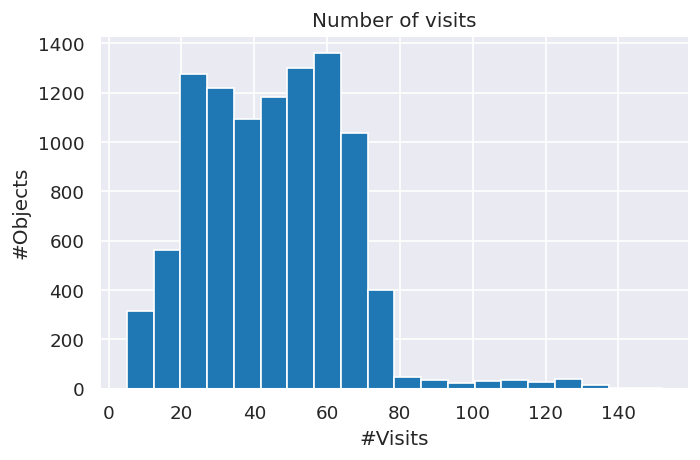

In [15]:
sn.set(font_scale=1.0)
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.hist(n, bins=20, color='tab:blue')
plt.minorticks_on()
plt.xlabel('#Visits')
plt.ylabel('#Objects')
plt.title('Number of visits')
plt.show()

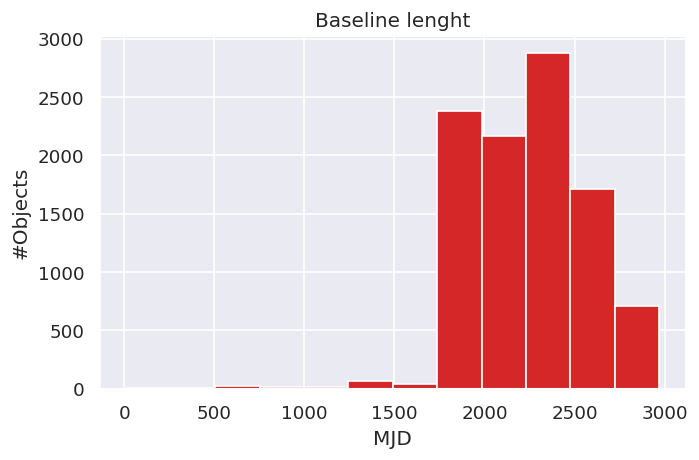

In [16]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.hist(bt, bins=12 , color='tab:red')
plt.minorticks_on()
plt.xlabel('MJD')
plt.ylabel('#Objects')
plt.title('Baseline lenght')
plt.show()

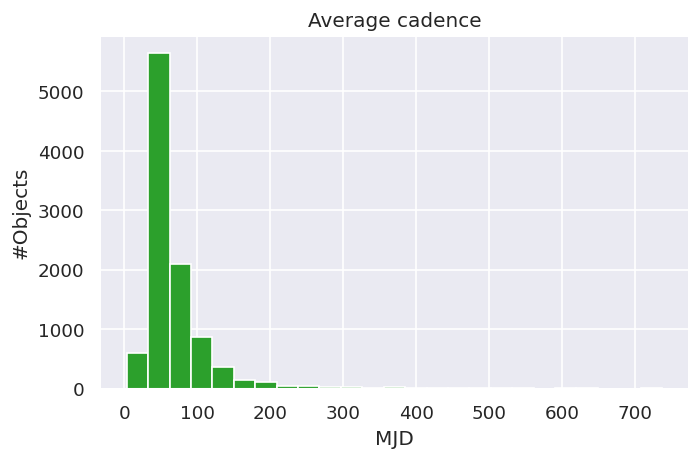

In [17]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.hist(cd, bins=25, color='tab:green')
plt.minorticks_on()
plt.xlabel('MJD')
plt.ylabel('#Objects')
plt.title('Average cadence')
plt.show()

#### Create lists with the indices of objects of each class (SDSS spectroscopic classification)

In [18]:
# Define empty arrays 
Agn = []
Gal = []
Qso = []
Star = []
highZQso = []
Indef = [] # Objects with no labels
# Define a boolean list for the Qso class, which will be used for evaluating the classification efficiency at the end of the code
Qso_truth = [] 
# Append the index
for i in range(len(n)):
    if classes[i] == 'Agn':
        Agn.append(i)
        Qso_truth.append('other')
    elif classes[i] == 'Gal':
        Gal.append(i)
        Qso_truth.append('other')
    elif classes[i] == 'Qso':
        Qso.append(i)
        Qso_truth.append('QSO')
    elif classes[i] == 'Star':
        Star.append(i)
        Qso_truth.append('other')
    elif classes[i] == 'highZQso':
        highZQso.append(i)
        Qso_truth.append('other')
    else:
        Indef.append(i)
        #Qso_truth.append('other') # Do not take into account "Indef" objects in the total

In [20]:
# How many objects are there in each class?
table = [['Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total'],
         [len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef),Sample]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╕
│   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │
╞═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╡
│    11 │  3308 │  1561 │   3487 │          4 │    1629 │   10000 │
╘═══════╧═══════╧═══════╧════════╧════════════╧═════════╧═════════╛


#### Examples of light curves

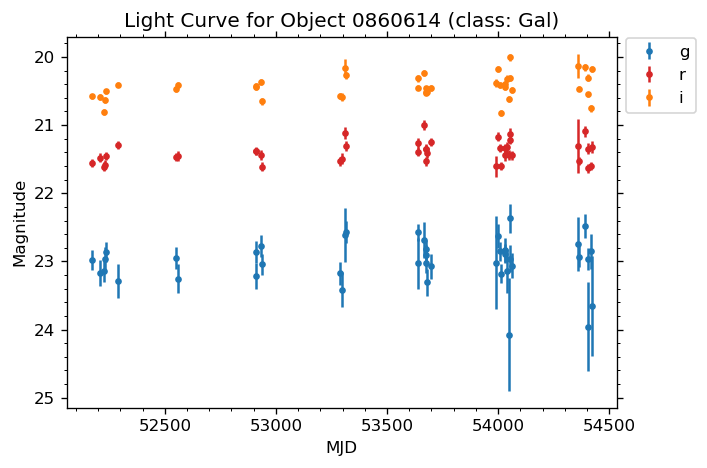

In [21]:
# Example of generic light curve
sn.reset_orig()
plt.rcParams.update({'xtick.top': True, 'ytick.right': True})
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.errorbar(t[25], psMag_g[25], psMagErr_g[25], fmt='.', color='tab:blue', label='g')
plt.errorbar(t[25], psMag_r[25], psMagErr_r[25], fmt='.', color='tab:red', label='r')
plt.errorbar(t[25], psMag_i[25], psMagErr_i[25], fmt='.', color='tab:orange', label='i')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.title('Light Curve for Object ' + indices[25] + ' (class: ' + classes[25] + ')')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
plt.show()

0860614 Gal


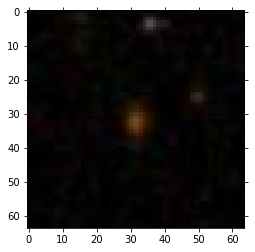

In [22]:
# Example of cutout
objectId = indices[25]
cutout = np.load(os.path.join(data_dir, f'cutouts/{objectId}.npy'))
plt.imshow(cutout)
print(objectId, classes[25])

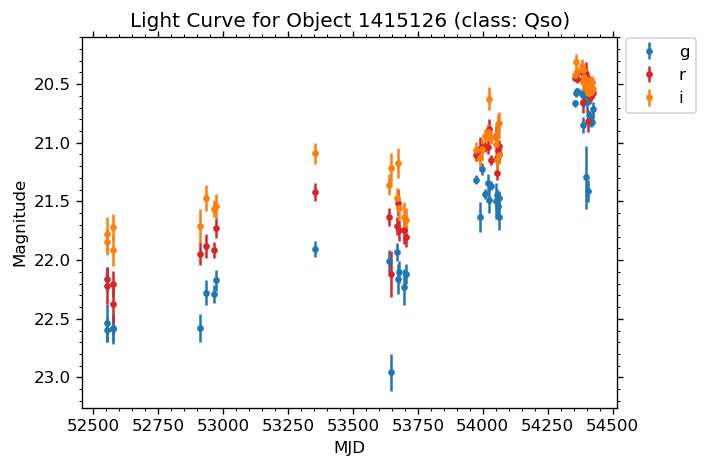

In [23]:
# Example of how to build a light curve for an object of selected class.
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.errorbar(t[Qso[31]], psMag_g[Qso[31]], psMagErr_g[Qso[31]], fmt='.', color='tab:blue', label='g')
plt.errorbar(t[Qso[31]], psMag_r[Qso[31]], psMagErr_r[Qso[31]], fmt='.', color='tab:red', label='r')
plt.errorbar(t[Qso[31]], psMag_i[Qso[31]], psMagErr_i[Qso[31]], fmt='.', color='tab:orange', label='i')
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.title('Light Curve for Object ' + indices[Qso[31]] + ' (class: ' + classes[Qso[31]] + ')')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
plt.show()

1415126 Qso


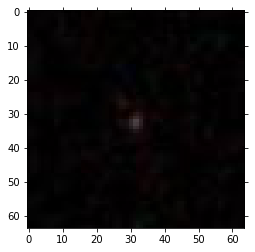

In [24]:
# Example of how to extract a cutout for an object of selected class
objectId = indices[Qso[31]]
cutout = np.load(os.path.join(data_dir, f'cutouts/{objectId}.npy'))
plt.imshow(cutout)
print(objectId, classes[Qso[31]])

### Homogenise the light curves and calculate the statistics

In this cell I calculate the *Average Magnitude*, the *Standard Deviation* and the *Pearson Correlation Index* for all the object in the Sample.

As a first thing, I homogenise the light curves so they have the same number of non-null visits in each band. Then, I reject the light curves having less than 10 non-null visits per band and I evaluate the statistics using a 3-sigma clipping.

In [25]:
# Define empty arrays with statstics on the light curves
avgMag_g = []
avgMag_r = []
avgMag_i = []
stdMag_g = []
stdMag_r = []
stdMag_i = []
corr_gr = []
corr_ri = []
corr_gi = []

#### Un-comment this lines if you want to append all the arrays into a file
#fields = ['indices', 'classes', 'avgMag_g', 'stdMag_g', 'avgMag_r', 'stdMag_r', 'avgMag_i', 'stdMag_i', 'corr_gr', 'corr_ri', 'corr_gi']
#with open('table_all.csv','a', newline='\n') as f:
    #writer = csv.writer(f)
    #writer.writerow(fields)

for index in range(len(n)):
    # Define masks to homogenise light curves so they have the same number of non-null visits in each band
    mask_gr = np.logical_or(np.isnan(psMag_g[index]),np.isnan(psMag_r[index]))
    mask_ri = np.logical_or(np.isnan(psMag_r[index]),np.isnan(psMag_i[index]))
    mask_gri = np.logical_or(mask_gr,mask_ri)   
    # Use only light curves with at least 10 non-null visits
    if len(psMag_g[index][~mask_gri]) >= 10:
        # Statistics with sigma clipping
        avgMag_g.append(np.mean((scipy.stats.sigmaclip(psMag_g[index][~mask_gri], low=3.0, high=3.0))[0]))
        avgMag_r.append(np.mean((scipy.stats.sigmaclip(psMag_r[index][~mask_gri], low=3.0, high=3.0))[0]))
        avgMag_i.append(np.mean((scipy.stats.sigmaclip(psMag_i[index][~mask_gri], low=3.0, high=3.0))[0]))
        stdMag_g.append(np.std((scipy.stats.sigmaclip(psMag_g[index][~mask_gri], low=3.0, high=3.0))[0]))
        stdMag_r.append(np.std((scipy.stats.sigmaclip(psMag_r[index][~mask_gri], low=3.0, high=3.0))[0]))
        stdMag_i.append(np.std((scipy.stats.sigmaclip(psMag_i[index][~mask_gri], low=3.0, high=3.0))[0]))
        # Correlation Index
        corr_gr.append(scipy.stats.pearsonr(psMag_g[index][~mask_gri], psMag_r[index][~mask_gri])[0])
        corr_ri.append(scipy.stats.pearsonr(psMag_r[index][~mask_gri], psMag_i[index][~mask_gri])[0])
        corr_gi.append(scipy.stats.pearsonr(psMag_g[index][~mask_gri], psMag_i[index][~mask_gri])[0])
    else: # Use NaN values for the rejected light curves
        avgMag_g.append(np.nan)
        avgMag_r.append(np.nan)
        avgMag_i.append(np.nan)
        stdMag_g.append(np.nan)
        stdMag_r.append(np.nan)
        stdMag_i.append(np.nan)
        corr_gr.append(np.nan)
        corr_ri.append(np.nan)
        corr_gi.append(np.nan)
        
    #### Un-comment this lines if you want to append all the arrays into a file
    #fields = [indices[index], classes[index], avgMag_g[index], stdMag_g[index], avgMag_r[index], stdMag_r[index], avgMag_i[index], stdMag_i[index], corr_gr[index], corr_ri[index], corr_gi[index]]
    #with open('table_all.csv','a', newline='\n') as f:
        #writer = csv.writer(f)
        #writer.writerow(fields)
        
# Convert into numpy arrays
avgMag_g = np.asarray(avgMag_g)
avgMag_r = np.asarray(avgMag_r)
avgMag_i = np.asarray(avgMag_i)
stdMag_g = np.asarray(stdMag_g)
stdMag_r = np.asarray(stdMag_r)
stdMag_i = np.asarray(stdMag_i)
corr_gr = np.asarray(corr_gr)
corr_ri = np.asarray(corr_ri)
corr_gi = np.asarray(corr_gi)

In [23]:
# This is how to select objects for a specific class

#for i in range(10):
    #print(classes[i],'  ',avgMag_g[i],'  ',avgMag_g[Qso[i]])
#print(avgMag_g)
#print(avgMag_g[Qso])
#print(len(avgMag_g))
#print(len(avgMag_g[Qso]))

### Analysis of the Correlation

Quasars are inherently variable, and correlation between different bands can be used to select them even if they show little variability. These two histograms show that the populations of Qso and Star are clearly separated from that of the Galaxies.
The same is true for AGNs in general, although in my analysis I focus only on QSOs because there are not enough objects labeled as AGN in the Sample. I will return later on the selection of AGNs through correlation and variability.

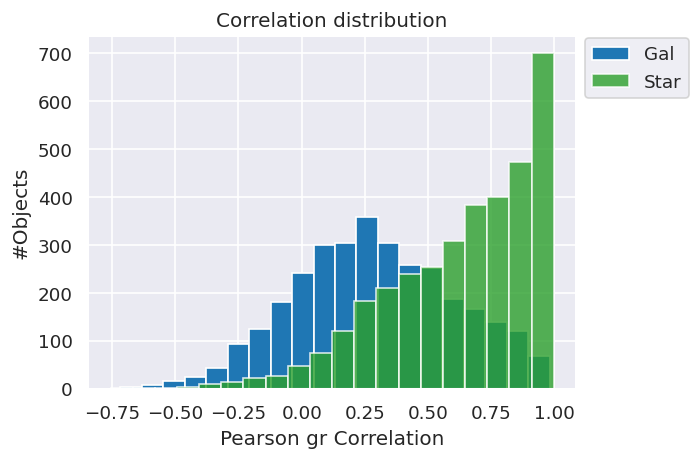

In [24]:
sn.set(font_scale=1.0)
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
#plt.hist(corr_gr[Qso], bins=20, color='tab:red', alpha=1.0, label='Qso')
plt.hist(corr_gr[Gal], bins=20, color='tab:blue', label='Gal')
plt.hist(corr_gr[Star], bins=20, color='tab:green',alpha=0.8, label='Star')
plt.minorticks_on()
plt.xlabel('Pearson gr Correlation')
plt.ylabel('#Objects')
plt.title('Correlation distribution')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
plt.show()

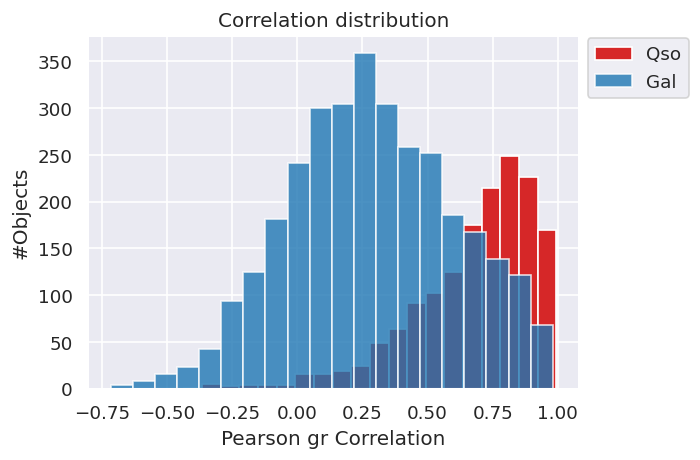

In [25]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.hist(corr_gr[Qso], bins=20, color='tab:red', alpha=1.0, label='Qso')
plt.hist(corr_gr[Gal], bins=20, color='tab:blue', alpha=0.8, label='Gal')
#plt.hist(corr_gr[Star], bins=20, color='tab:green', alpha=0.8, label='Star')
plt.minorticks_on()
plt.xlabel('Pearson gr Correlation')
plt.ylabel('#Objects')
plt.title('Correlation distribution')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
plt.show()

#### Here I show, as an example, the correlation plot for the Qso of the previous light curve

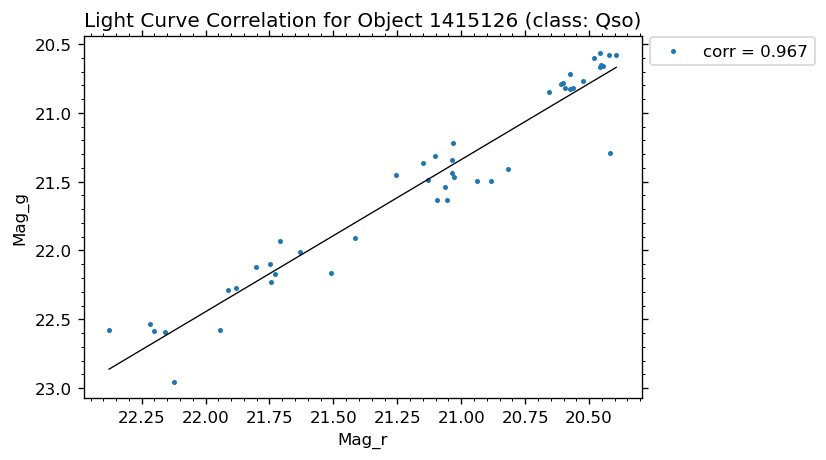

In [26]:
sn.reset_orig()
plt.rcParams.update({'xtick.top': True, 'ytick.right': True})
fig = plt.figure(figsize=(6, 4), dpi=120)
plt.scatter(psMag_r[Qso[31]], psMag_g[Qso[31]], s=4, c='tab:blue', label='corr = ' + '%.5s'%corr_gr[Qso[31]])
idx = np.isfinite(psMag_r[Qso[31]]) & np.isfinite(psMag_g[Qso[31]]) # Reject NaN values
plt.plot(np.unique(psMag_r[Qso[31]][idx]), np.poly1d(np.polyfit(psMag_r[Qso[31]][idx], psMag_g[Qso[31]][idx], 1))(np.unique(psMag_r[Qso[31]][idx])),linewidth=0.8, color='black')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.minorticks_on()
plt.xlabel('Mag_r')
plt.ylabel('Mag_g')
plt.title('Light Curve Correlation for Object ' + indices[Qso[31]] + ' (class: ' + classes[Qso[31]] + ')')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
plt.show()

## Selection of QSOs from the Sample 

### 1) Variability information

A simple plot with *Standard Deviation vs Average Magnitude* is not enough to select QSOs as many of them would be below any variability threshold, as you can se from the image below (you can "interact" with the plot by commenting or un-commenting the lines with the different classes). 

Perhaps the *Difference Image Analysis* could improve this selection technique when the survey will start, but for now, using the data provided for this Data Challenge, I tried to join variability and correlation to assess the classification efficiency of QSOs.

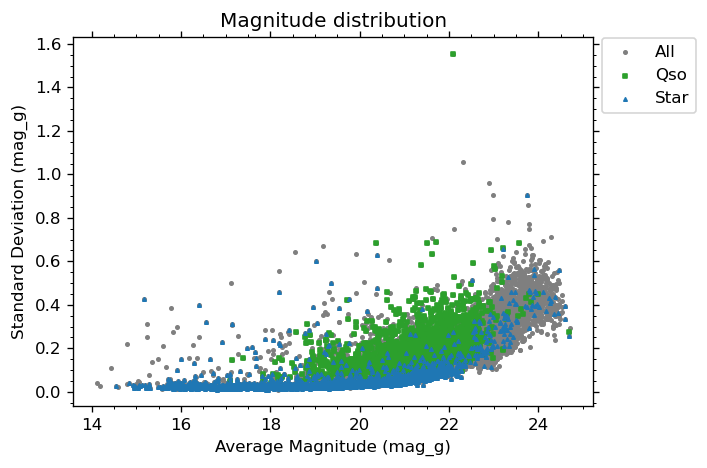

In [27]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.scatter(avgMag_g, stdMag_g, marker='o', s=4, c='tab:grey', label='All')
plt.scatter(avgMag_g[Qso], stdMag_g[Qso], marker='s', s=4, c='tab:green', label='Qso')
plt.scatter(avgMag_g[Star], stdMag_g[Star], marker='^', s=4, c='tab:blue', label='Star')
#plt.scatter(avgMag_g[Agn], stdMag_g[Agn], marker='^', s=4, c='tab:red', label='Agn')
#plt.scatter(avgMag_g[Gal], stdMag_g[Gal], marker='^', s=4, c='tab:pink', label='Gal')
plt.minorticks_on()
plt.xlabel('Average Magnitude (mag_g)')
plt.ylabel('Standard Deviation (mag_g)')
plt.title('Magnitude distribution')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
#### Un-comment this cell if you want to save this plot into a file (useful for an asynchronous run on the full dataset)
#plt.savefig('mags.jpg')
plt.show()

Here I plot the *Standard Deviation* against the *gr-correlation*, using a log-axes on the y and color-coding the points according to the *Average Magnitude*. It is clearly evident a splitting between bright and faint sources. 

Galaxies tend to be clusterised in the upper stripe of the plot, while Stars tend to be in the lower block. QSOs and AGNs are mostly in a wedge on the upper-right.

N.B. You can *"interact"* with the plot by commenting and un-commenting the lines with the different classes of Objects.

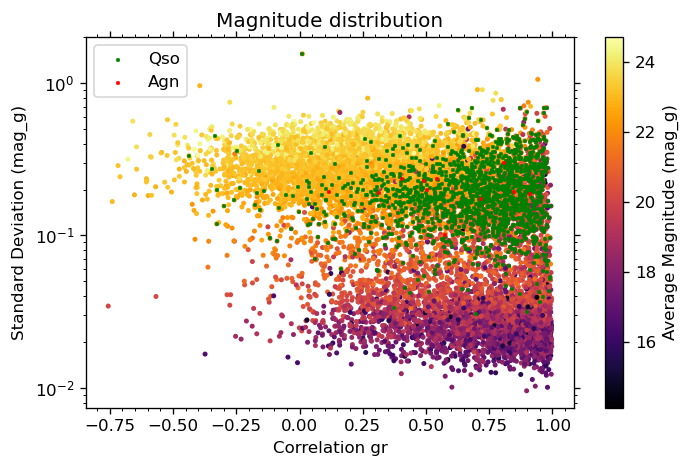

In [28]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.scatter(corr_gr, stdMag_g, marker='o', s=4, c=avgMag_g, cmap='inferno')
plt.colorbar(orientation='vertical', label='Average Magnitude (mag_g)')
plt.scatter(corr_gr[Qso], stdMag_g[Qso], marker='s', s=3, c='green', label='Qso')
plt.scatter(corr_gr[Agn], stdMag_g[Agn], marker='s', s=3, c='red', label='Agn')
#plt.scatter(corr_gr[Gal], stdMag_g[Gal], marker='s', s=3, c='pink', label='Gal')
#plt.scatter(corr_gr[Star], stdMag_g[Star], marker='s', s=3, c='blue', label='Star')
plt.minorticks_on()
plt.xlabel('Correlation gr')
plt.ylabel('Standard Deviation (mag_g)')
plt.yscale('log')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

I define a Wedge on this plot and calculate *Completeness* and *Purity* of the QSOs selection for the objects inside the Wedge.

There are certainly better ways to define a Wedge, but for the purpose of this Data Challenge I simply drew lines by eye inspection to test the idea. 

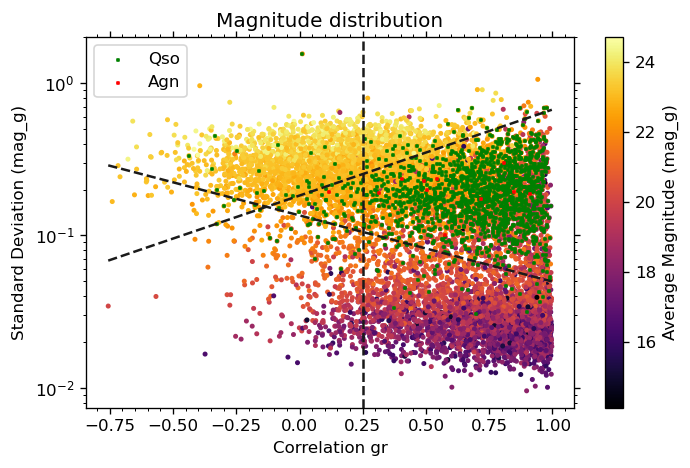

In [26]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.scatter(corr_gr, stdMag_g, marker='o', s=4, c=avgMag_g, cmap='inferno')
plt.colorbar(orientation='vertical', label='Average Magnitude (mag_g)')
plt.scatter(corr_gr[Qso], stdMag_g[Qso], marker='s', s=3, c='green', label='Qso')
plt.scatter(corr_gr[Agn], stdMag_g[Agn], marker='s', s=3, c='red', label='Agn')
#plt.scatter(corr_gr[Gal], stdMag_g[Gal], marker='s', s=3, c='pink', label='Gal')
#plt.scatter(corr_gr[Star], stdMag_g[Star], marker='s', s=3, c='blue', label='Star')

# Wedge lines
line_x = np.sort(corr_gr)
line_y1 = np.exp(1.3*(line_x) - 1.7)
line_y2 = np.exp(-1*(line_x) - 2)
plt.plot(line_x, line_y1,  ls='--', c='k')
plt.plot(line_x, line_y2,  ls='--', c='k')
plt.axvline(x=0.25, ls='--', c='k')

plt.minorticks_on()
plt.xlabel('Correlation gr')
plt.ylabel('Standard Deviation (mag_g)')
plt.yscale('log')
plt.title('Magnitude distribution')
plt.legend()
#### Un-comment this cell if you want to save this plot into a file (useful for an asynchronous run on the full dataset)
#plt.savefig('wedge_1.jpg')
plt.show()

In [29]:
# This function defines a mask with the indices of the points within the Wedge (it will take a couple of minutes to run)
mask_wedge = []
for i in range(len(line_x)):
    for j in range(len(line_x)):
        if corr_gr[i] > 0.25 and corr_gr[i] == line_x[j] and stdMag_g[i] < line_y1[j] and stdMag_g[i] > line_y2[j]:
            mask_wedge.append(i)
        else:
            continue
mask_wedge = np.asarray(mask_wedge)

In [32]:
# Define arrays with indices of the points within the Wedge for each class
Agn_wedge = np.intersect1d(Agn,mask_wedge)
Gal_wedge = np.intersect1d(Gal,mask_wedge)
Qso_wedge = np.intersect1d(Qso,mask_wedge)
Star_wedge = np.intersect1d(Star,mask_wedge)
highZQso_wedge = np.intersect1d(highZQso,mask_wedge)
Indef_wedge = np.intersect1d(Indef,mask_wedge)

In [33]:
# Calculate Completeness and Purity (wedge)
Completeness_wedge = (len(Qso_wedge)/len(Qso))*100
Purity_wedge = (len(Qso_wedge)/(len(mask_wedge)-len(Indef_wedge)))*100

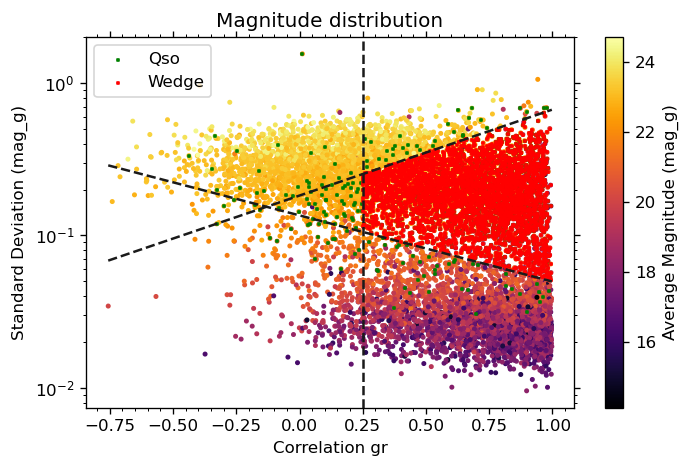

In [34]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
plt.scatter(corr_gr, stdMag_g, marker='o', s=4, c=avgMag_g, cmap='inferno')
plt.colorbar(orientation='vertical', label='Average Magnitude (mag_g)')
plt.scatter(corr_gr[Qso], stdMag_g[Qso], marker='s', s=3, c='green', label='Qso')
plt.scatter(corr_gr[mask_wedge], stdMag_g[mask_wedge], marker='s', s=3, c='red', label='Wedge')
# Wedge lines
line_x = np.sort(corr_gr)
line_y1 = np.exp(1.3*(line_x) - 1.7)
line_y2 = np.exp(-1*(line_x) - 2)
plt.plot(line_x, line_y1,  ls='--', c='k')
plt.plot(line_x, line_y2,  ls='--', c='k')
plt.axvline(x=0.25, ls='--', c='k')

plt.minorticks_on()
plt.xlabel('Correlation gr')
plt.ylabel('Standard Deviation (mag_g)')
plt.yscale('log')
plt.title('Magnitude distribution')
plt.legend()
#### Un-comment this cell if you want to save this plot into a file (useful for an asynchronous run on the full dataset)
#plt.savefig('wedge_2.jpg')
plt.show()

#### Confusion Matrix for the objects within the Wedge

In [35]:
# Define a QSO_wedge_truth array to be used with QSO_truth to plot a confusion matrix
wedge_truth = []
for i in range(Sample):
    if i in mask_wedge and i not in Indef: # Do not take into account "Indef" object in the total
        wedge_truth.append('QSO')
    elif i in Indef:
        continue
    else:
        wedge_truth.append('other')

In [36]:
y_true = Qso_truth
y_pred = wedge_truth
cm = confusion_matrix(y_true, y_pred)
#print(cm)

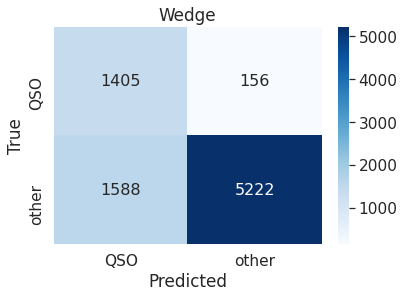

In [38]:
cm_labels = np.unique(y_true)
df_cm = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}) # font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Wedge')
plt.show()

#### Summary Table

The Completeness of the selection of QSOs using the Wedge is very high, but the Purity is low and there are lots of Gal contaminants. It is therfore necessary to use other criteria to remove these contaminants. 
It is also interesting to note that almost all the AGNs fall within the Wedge. 

**WARNING:** I have not taken into account objects without *class* labels (i.e., the *Indef*) in the Confusion Matrix and for the evaluation of *Completeness* and *Purity*.

The *Completeness* is calculated as:  (QSO_selected) / (QSO_tot).

The *Purity* is calculated as:  (QSO_selected) / (tot_selected - Indef_selected).

In [39]:
table = [['','Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total','Completeness (Qso)','Purity (Qso)'],
         ['Sample',len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef),Sample,'',''],
         ['Wedge',len(Agn_wedge),len(Gal_wedge),len(Qso_wedge),len(Star_wedge),len(highZQso_wedge),
          len(Indef_wedge),len(mask_wedge),"%.1f" % Completeness_wedge+' %',"%.1f" % Purity_wedge+' %']]

In [40]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════╤═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╤══════════════════════╤════════════════╕
│        │   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │ Completeness (Qso)   │ Purity (Qso)   │
╞════════╪═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╪══════════════════════╪════════════════╡
│ Sample │    11 │  3308 │  1561 │   3487 │          4 │    1629 │   10000 │                      │                │
├────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Wedge  │    10 │  1266 │  1405 │    312 │          0 │     763 │    3766 │ 90.0 %               │ 46.8 %         │
╘════════╧═══════╧═══════╧═══════╧════════╧════════════╧═════════╧═════════╧══════════════════════╧════════════════╛


### 2) Extension information 

To get rid of the contamination of Galaxies, I use the *extendeness parameter*. By plotting the cumulative distribution, I decide to take all the objects with *extendeness_g < 0.9*. 

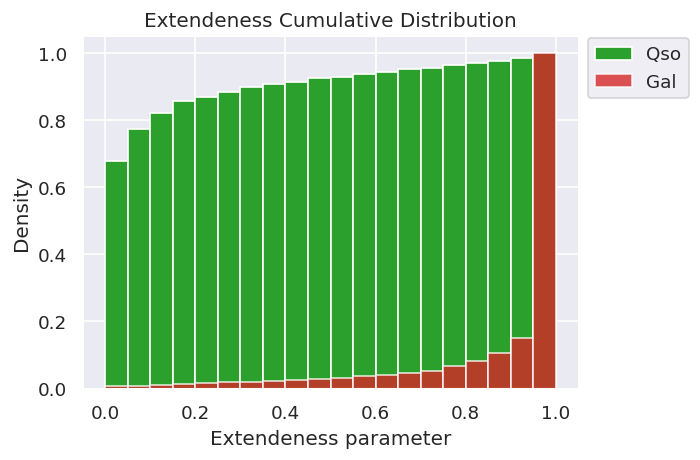

In [41]:
sn.set(font_scale=1.0)
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
#plt.hist(extendeness_g[:Sample], bins=20, density=True, cumulative=True, color='tab:grey', label='All')
plt.hist(extendeness_g[Qso], bins=20, density=True, cumulative=True, color='tab:green', label='Qso')
plt.hist(extendeness_g[Gal], bins=20, density=True, cumulative=True, alpha=0.8, color='tab:red', label='Gal')
#plt.hist(extendeness_g[Star], bins=20, density=True, cumulative=True, alpha=0.5, color='tab:blue', label='Star')
plt.minorticks_on()
plt.xlabel('Extendeness parameter')
plt.ylabel('Density')
plt.title('Extendeness Cumulative Distribution')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
#### Un-comment this cell if you want to save this plot into a file (useful for an asynchronous run on the full dataset)
#plt.savefig('extendeness_cumulative.jpg')
plt.show()

In [42]:
# This function defines a mask with the indices of the points with extendeness_g < 0.9
mask_ext = []
for index in range(Sample):
    if extendeness_g[index] < 0.9:
        mask_ext.append(index)
    else:
        continue
mask_ext = np.asarray(mask_ext)

In [43]:
# Define a mask with the indices of the points within the Wedge and with  extendeness_g < 0.9
mask_wedge_ext = np.intersect1d(mask_wedge,mask_ext)

In [44]:
# Define arrays with indices of the points with extendeness_g < 0.9 for each class
Agn_ext = np.intersect1d(Agn,mask_ext)
Gal_ext = np.intersect1d(Gal,mask_ext)
Qso_ext = np.intersect1d(Qso,mask_ext)
Star_ext = np.intersect1d(Star,mask_ext)
highZQso_ext = np.intersect1d(highZQso,mask_ext)
Indef_ext = np.intersect1d(Indef,mask_ext)

In [45]:
# Define arrays with indices of the points within the Wedge and with  extendeness_g < 0.9 for each class
Agn_wedge_ext = np.intersect1d(Agn,mask_wedge_ext)
Gal_wedge_ext = np.intersect1d(Gal,mask_wedge_ext)
Qso_wedge_ext = np.intersect1d(Qso,mask_wedge_ext)
Star_wedge_ext = np.intersect1d(Star,mask_wedge_ext)
highZQso_wedge_ext = np.intersect1d(highZQso,mask_wedge_ext)
Indef_wedge_ext = np.intersect1d(Indef,mask_wedge_ext)

In [46]:
# Calculate Completeness and Purity (extendeness only)
Completeness_ext = (len(Qso_ext)/len(Qso))*100
Purity_ext = (len(Qso_ext)/(len(mask_ext)-len(Indef_ext)))*100
# Calculate Completeness and Purity (wedge+ext)
Completeness_wedge_ext = (len(Qso_wedge_ext)/len(Qso))*100
Purity_wedge_ext = (len(Qso_wedge_ext)/(len(mask_wedge_ext)-len(Indef_wedge_ext)))*100

#### Confusion Matrix

In [47]:
# Define a QSO_wedge_ext_truth array to be used with QSO_truth to plot a confusion matrix
wedge_ext_truth = []
for i in range(Sample):
    if i in mask_wedge_ext and i not in Indef: # Do not take into account "Indef" object in the total
        wedge_ext_truth.append('QSO')
    elif i in Indef:
        continue
    else:
        wedge_ext_truth.append('other')

In [48]:
y_true = Qso_truth
y_pred = wedge_ext_truth
cm = confusion_matrix(y_true, y_pred)
#print(cm)

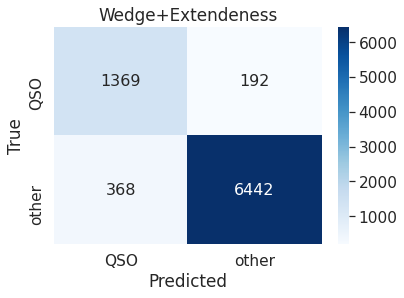

In [49]:
cm_labels = np.unique(y_true)
df_cm = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}) # font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Wedge+Extendeness')
plt.show()

#### Summary table

The *Extension* alone is not a good way to select QSOs, because it has a lot of Star contaminants. However, if coupled with the *Wedge*, it contributes to raise the *Purity* while only slightly reducing the *Completeness*.

In [50]:
table = [['','Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total','Completeness (Qso)','Purity (Qso)'],
         ['Sample',len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef),Sample,'',''],
         ['Ext',len(Agn_ext),len(Gal_ext),len(Qso_ext),len(Star_ext),len(highZQso_ext),len(Indef_ext),len(mask_ext),"%.1f" % Completeness_ext+' %',"%.1f" % Purity_ext+' %'],
        ['Wedge+ext',len(Agn_wedge_ext),len(Gal_wedge_ext),len(Qso_wedge_ext),len(Star_wedge_ext),len(highZQso_wedge_ext),len(Indef_wedge_ext),len(mask_wedge_ext),"%.1f" % Completeness_wedge_ext+' %',"%.1f" % Purity_wedge_ext+' %'],
        ]

In [51]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╤══════════════════════╤════════════════╕
│           │   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │ Completeness (Qso)   │ Purity (Qso)   │
╞═══════════╪═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╪══════════════════════╪════════════════╡
│ Sample    │    11 │  3308 │  1561 │   3487 │          4 │    1629 │   10000 │                      │                │
├───────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Ext       │     0 │   344 │  1518 │   3394 │          2 │    1038 │    6296 │ 97.2 %               │ 28.9 %         │
├───────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Wedge+ext │     0 │    96 │  1369 │    272 │          0 │     544 │    2281 │ 87.7 %               │ 78.8 %         │
╘═══════════╧═══════╧═══════╧═══════╧═══

### 3) Color information

Now I also add the Color information to see if this can improve the selection. 

With a *r-i vs g-r* diagram, I can well separate Gal, Qso and Star. Therefore, I define a box on the plot and select all the objects within it.

Again, there are certainly better criteria to define a region on this diagram, but for the purpose of this Data Challenge I simply drew lines by eye inspection to test the idea.

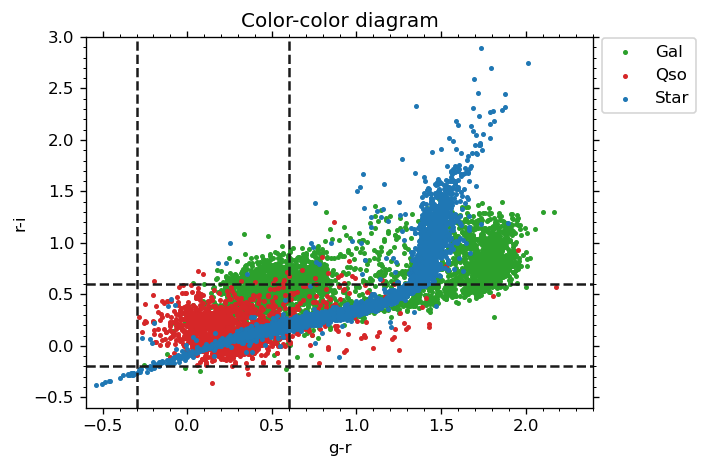

In [52]:
sn.reset_orig()
plt.rcParams.update({'xtick.top': True, 'ytick.right': True})

fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
#plt.scatter(stdColor_1[:Sample], stdColor_2[:Sample], marker='o', s=4, c='tab:grey', label='All')
plt.scatter(stdColor_1[Gal], stdColor_2[Gal], marker='o', s=4, c='tab:green', label='Gal')
plt.scatter(stdColor_1[Qso], stdColor_2[Qso], marker='o', s=4, c='tab:red', label='Qso')
plt.scatter(stdColor_1[Star], stdColor_2[Star], marker='o', s=4, c='tab:blue', label='Star')

# Box lines
plt.axhline(y=-0.2, ls='--', c='k')
plt.axhline(y=0.6, ls='--', c='k')
plt.axvline(x=-0.3, ls='--', c='k')
plt.axvline(x=0.6, ls='--', c='k')

plt.minorticks_on()
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.title('Color-color diagram')
plt.ylim((-0.6,3.0))
plt.xlim((-0.6,2.4))
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
#### Un-comment this cell if you want to save this plot into a file (useful for an asynchronous run on the full dataset)
#plt.savefig('Color-selection.jpg')
plt.show()

This is the same plot, using only the objects in *Wedge+extendeness*. As you can see, most of the Galaxy contaminants have already been removed by the extension criterion, but the color helps to reject some Star.

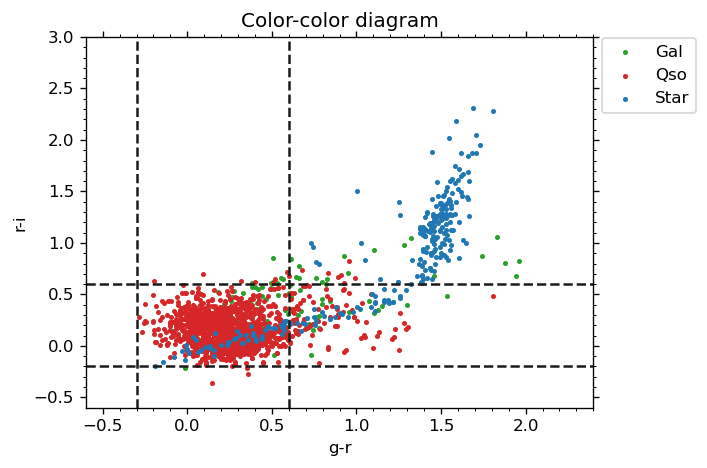

In [53]:
fig = plt.figure(figsize=(6, 4), dpi=120, tight_layout=True)
#plt.scatter(stdColor_1[:Sample], stdColor_2[:Sample], marker='o', s=4, c='tab:grey', label='All')
plt.scatter(stdColor_1[Gal_wedge_ext], stdColor_2[Gal_wedge_ext], marker='o', s=4, c='tab:green', label='Gal')
plt.scatter(stdColor_1[Qso_wedge_ext], stdColor_2[Qso_wedge_ext], marker='o', s=4, c='tab:red', label='Qso')
plt.scatter(stdColor_1[Star_wedge_ext], stdColor_2[Star_wedge_ext], marker='o', s=4, c='tab:blue', label='Star')

# Box lines
plt.axhline(y=-0.2, ls='--', c='k')
plt.axhline(y=0.6, ls='--', c='k')
plt.axvline(x=-0.3, ls='--', c='k')
plt.axvline(x=0.6, ls='--', c='k')

plt.minorticks_on()
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.title('Color-color diagram')
plt.ylim((-0.6,3.0))
plt.xlim((-0.6,2.4))
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)
#### Un-comment this cell if you want to save this plot into a file (useful for an asynchronous run on the full dataset)
#plt.savefig('color_selection_2.jpg')
plt.show()

In [54]:
# This function defines a mask with the indices of the points within the Box
mask_box = []
for index in range(Sample):
    if stdColor_1[:Sample][index] > -0.3 and stdColor_1[:Sample][index] < 0.6 and stdColor_2[:Sample][index] > -0.2 and stdColor_2[:Sample][index] < 0.6:
        mask_box.append(index)
    else:
        continue
mask_box = np.asarray(mask_box)

In [55]:
# Define a mask with the indices of the points within the Wedge and the Box and with extendeness_g < 0.9
mask_wedge_ext_box = np.intersect1d(mask_wedge_ext,mask_box)
# Define a mask with the indices of the points within the Wedge and the Box
mask_wedge_box = np.intersect1d(mask_wedge,mask_box)
# Define a mask with the indices of the points within the Box and with extendeness_g < 0.9
mask_box_ext = np.intersect1d(mask_box,mask_ext)

In [56]:
# Define arrays with indices of the points within the Box
Agn_box = np.intersect1d(Agn,mask_box)
Gal_box = np.intersect1d(Gal,mask_box)
Qso_box = np.intersect1d(Qso,mask_box)
Star_box = np.intersect1d(Star,mask_box)
highZQso_box = np.intersect1d(highZQso,mask_box)
Indef_box = np.intersect1d(Indef,mask_box)

In [57]:
# Define arrays with indices of the points within the Wedge and the Box
Agn_wedge_box = np.intersect1d(Agn,mask_wedge_box)
Gal_wedge_box = np.intersect1d(Gal,mask_wedge_box)
Qso_wedge_box = np.intersect1d(Qso,mask_wedge_box)
Star_wedge_box = np.intersect1d(Star,mask_wedge_box)
highZQso_wedge_box = np.intersect1d(highZQso,mask_wedge_box)
Indef_wedge_box = np.intersect1d(Indef,mask_wedge_box)

In [58]:
# Define arrays with indices of the points within the Box and with  extendeness_g < 0.9 for each class
Agn_box_ext = np.intersect1d(Agn,mask_box_ext)
Gal_box_ext = np.intersect1d(Gal,mask_box_ext)
Qso_box_ext = np.intersect1d(Qso,mask_box_ext)
Star_box_ext = np.intersect1d(Star,mask_box_ext)
highZQso_box_ext = np.intersect1d(highZQso,mask_box_ext)
Indef_box_ext = np.intersect1d(Indef,mask_box_ext)

In [59]:
# Define arrays with indices of the points within the Wedge, the Box and with  extendeness_g < 0.9 for each class
Agn_wedge_ext_box = np.intersect1d(Agn,mask_wedge_ext_box)
Gal_wedge_ext_box = np.intersect1d(Gal,mask_wedge_ext_box)
Qso_wedge_ext_box = np.intersect1d(Qso,mask_wedge_ext_box)
Star_wedge_ext_box = np.intersect1d(Star,mask_wedge_ext_box)
highZQso_wedge_ext_box = np.intersect1d(highZQso,mask_wedge_ext_box)
Indef_wedge_ext_box = np.intersect1d(Indef,mask_wedge_ext_box)

In [60]:
# Calculate Completeness and Purity (color only)
Completeness_box = (len(Qso_box)/len(Qso))*100
Purity_box = (len(Qso_box)/(len(mask_box)-len(Indef_box)))*100
# Calculate Completeness and Purity (wedge+box)
Completeness_wedge_box = (len(Qso_wedge_box)/len(Qso))*100
Purity_wedge_box = (len(Qso_wedge_box)/(len(mask_wedge_box)-len(Indef_wedge_box)))*100
# Calculate Completeness and Purity (box+ext)
Completeness_box_ext = (len(Qso_box_ext)/len(Qso))*100
Purity_box_ext = (len(Qso_box_ext)/(len(mask_box_ext)-len(Indef_box_ext)))*100
# Calculate Completeness and Purity (wedge+ext+box)
Completeness_wedge_ext_box = (len(Qso_wedge_ext_box)/len(Qso))*100
Purity_wedge_ext_box = (len(Qso_wedge_ext_box)/(len(mask_wedge_ext_box)-len(Indef_wedge_ext_box)))*100

#### Confusion Matrix

In [61]:
# Define a QSO_wedge_ext_box_truth array to be used with QSO_truth to plot a confusion matrix
wedge_ext_box_truth = []
for i in range(Sample):
    if i in mask_wedge_ext_box and i not in Indef: # Do not take into account "Indef" object in the total
        wedge_ext_box_truth.append('QSO')
    elif i in Indef:
        continue
    else:
        wedge_ext_box_truth.append('other')

In [62]:
y_true = Qso_truth
y_pred = wedge_ext_box_truth
cm = confusion_matrix(y_true, y_pred)
#print(cm)

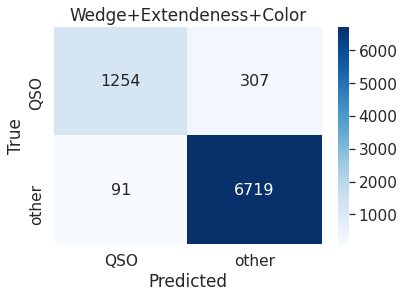

In [63]:
cm_labels = np.unique(y_true)
df_cm = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}) # font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Wedge+Extendeness+Color')
plt.show()

### Final summary table

In this table, I summarize the results obtained with all the three criteria used alone or combined with each other. 

The best outcome is of course obtained using all the criteria together, but it is important to stress the great contribution given by the *Wedge* (i.e., the correlation between different bands). If coupled with the *Extension* or the *Color*, it performs far better than the pair *Color + Extension* and even alone it leads to a higher purity than the other criteria alone.

In [64]:
table = [['','Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total','Completeness (Qso)','Purity (Qso)'],
         ['Sample',len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef),Sample,'',''],
         ['Wedge',len(Agn_wedge),len(Gal_wedge),len(Qso_wedge),len(Star_wedge),len(highZQso_wedge),len(Indef_wedge),len(mask_wedge),"%.1f" % Completeness_wedge+' %',"%.1f" % Purity_wedge+' %'],
         ['Ext',len(Agn_ext),len(Gal_ext),len(Qso_ext),len(Star_ext),len(highZQso_ext),len(Indef_ext),len(mask_ext),"%.1f" % Completeness_ext+' %',"%.1f" % Purity_ext+' %'],
         ['Col',len(Agn_box),len(Gal_box),len(Qso_box),len(Star_box),len(highZQso_box),len(Indef_box),len(mask_box),"%.1f" % Completeness_box+' %',"%.1f" % Purity_box+' %'],
        ['Wedge+Ext',len(Agn_wedge_ext),len(Gal_wedge_ext),len(Qso_wedge_ext),len(Star_wedge_ext),len(highZQso_wedge_ext),len(Indef_wedge_ext),len(mask_wedge_ext),"%.1f" % Completeness_wedge_ext+' %',"%.1f" % Purity_wedge_ext+' %'],
         ['Col+Ext',len(Agn_box_ext),len(Gal_box_ext),len(Qso_box_ext),len(Star_box_ext),len(highZQso_box_ext),len(Indef_box_ext),len(mask_box_ext),"%.1f" % Completeness_box_ext+' %',"%.1f" % Purity_box_ext+' %'],
         ['Wedge+Col',len(Agn_wedge_box),len(Gal_wedge_box),len(Qso_wedge_box),len(Star_wedge_box),len(highZQso_wedge_box),len(Indef_wedge_box),len(mask_wedge_box),"%.1f" % Completeness_wedge_box+' %',"%.1f" % Purity_wedge_box+' %'],
        ['Wedge+Ext+Col',len(Agn_wedge_ext_box),len(Gal_wedge_ext_box),len(Qso_wedge_ext_box),len(Star_wedge_ext_box),len(highZQso_wedge_ext_box),len(Indef_wedge_ext_box),len(mask_wedge_ext_box),"%.1f" % Completeness_wedge_ext_box+' %',"%.1f" % Purity_wedge_ext_box+' %'],
        ]

In [65]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╤══════════════════════╤════════════════╕
│               │   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │ Completeness (Qso)   │ Purity (Qso)   │
╞═══════════════╪═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╪══════════════════════╪════════════════╡
│ Sample        │    11 │  3308 │  1561 │   3487 │          4 │    1629 │   10000 │                      │                │
├───────────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Wedge         │    10 │  1266 │  1405 │    312 │          0 │     763 │    3766 │ 90.0 %               │ 46.8 %         │
├───────────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Ext           │     0 │   344 │  1518 │   3394 │          2 │    1038 │    6296 │ 97.2 %               │ 28.9 %         │
├───────

In [64]:
#### Un-comment this cell if you want to save the Summary Table into a file (useful for an asynchronous run on the full dataset)
#with open('table.csv', 'w') as f:
    #f.write(tabulate(table))

Based on my classification, the *Indef* objects (i.e., without labels) which are selected in *Wedge+Ext+Col* would be classified as *QSO candidate*.
The cell below reports the indices of these objects to check the classification efficiency.

In [65]:
print('There are', len(Indef_wedge_ext_box), 'new QSO canddates in the Wedge+Ext+Col selection.')
# These are the indices of the Indef objects in Wedge+Ext+Col.
#print(indices[Indef_wedge_ext_box])
# To obtain info for the other classes, use: "array[class_selection_criteria]"

There are 379 new QSO canddates in the Wedge+Ext+Col selection.


### Conclusions

The main purpose of this notebook was to explore the possibility of selecting QSOs (and perhaps AGNs in general), using simple statistics obtained from the light curves. Although more complicated approaches with other statistical indicators are certainly possible, here it is shown that even the simplest ones perform very well in the selection of QSOs. 

Variability alone, using the *Wedge* defined with variance and correlation, can lead to a Completeness of ~ 90 % for both QSOs and AGNs. By adding the Extendeness or the Color as well, it is possible to remove most of the contaminants reaching a Purity ~ 90 % and decreasing the Completeness of just a ~ 10 % for the QSOs, while the selection of AGNs would require different indicators to reduce the contamination. 

Future improvements to this work could be a deeper analysis of the correlation properties and the exploration of other parameters to extend the classification to the AGNs, which are well selected by the *Wedge* but with high degree of contamination.

### => WY: Test on Blinded Dataset <=

#### 1. Read the blinded dataset & select those with LC

In [67]:
# read whole dataset
object_blinded_df = pd.read_parquet(os.path.join(data_dir, 'ObjectTable_Blinded.parquet'))

# select those having LCs
lc_cols = [col for col in object_df.columns if 'Periodic' ind col]
object_blinded_df = object_blinded_df.dropna(subset=lc_cols, how='all').copy()
object_blinded_df.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo

#### 2. Extract features into lists

In [68]:
# features from the object table
indices = np.asarray(object_blinded_df.index)
classes = np.asarray(object_blinded_df[object_blinded_df.columns[69]])
extendeness_g = np.asarray(object_blinded_df[object_blinded_df.columns[54]])
extendeness_r = np.asarray(object_blinded_df[object_blinded_df.columns[55]])
extendeness_i = np.asarray(object_blinded_df[object_blinded_df.columns[56]])
stdColor_0 = np.asarray(object_blinded_df[object_blinded_df.columns[59]])
stdColor_1 = np.asarray(object_blinded_df[object_blinded_df.columns[60]])
stdColor_2 = np.asarray(object_blinded_df[object_blinded_df.columns[61]])
stdColor_3 = np.asarray(object_blinded_df[object_blinded_df.columns[62]])
stdColor_4 = np.asarray(object_blinded_df[object_blinded_df.columns[63]])

In [76]:
# collect & store light curves
# Array with number of visits
n = []
# Array with dates
t = []
# Array with baselines (max - min)
bt = []
# Arrays with cadences (average MJD difference)
cd = []

# Arrays with magnitudes
# g_band 
psMag_g = []
psMagErr_g = []
# r_band
psMag_r = []
psMagErr_r = []
# i_band
psMag_i = []
psMagErr_i = []

# Define the lenght of the random sample used to test the algorithm
for j, index in enumerate(indices[:]):
    # Get the light curve
    lc = fs_gp.get_group(index)
    lc = lc.sort_values('mjd')
    # Put into five different bands
    lc_bands = {}
    for i, b in enumerate('ugriz'):
        lc_bands[b] = lc[lc['filter'] == i]
    t.append(np.asarray(lc_bands['u'].mjd))
    n.append(len(t[j]))
    bt.append(max_min(t[j]))
    cd.append(mean_cadence(t[j]))
    # g_band
    psMag_g.append(np.asarray(lc_bands['g'].psMag))
    psMagErr_g.append(np.asarray(lc_bands['g'].psMagErr))
    # r_band
    psMag_r.append(np.asarray(lc_bands['r'].psMag))
    psMagErr_r.append(np.asarray(lc_bands['r'].psMagErr))
    # i_band
    psMag_i.append(np.asarray(lc_bands['i'].psMag))
    psMagErr_i.append(np.asarray(lc_bands['i'].psMagErr))

In [77]:
# Define empty arrays with statstics on the light curves
avgMag_g = []
avgMag_r = []
avgMag_i = []
stdMag_g = []
stdMag_r = []
stdMag_i = []
corr_gr = []
corr_ri = []
corr_gi = []

for index in range(len(n)):
    # Define masks to homogenise light curves so they have the same number of non-null visits in each band
    mask_gr = np.logical_or(np.isnan(psMag_g[index]),np.isnan(psMag_r[index]))
    mask_ri = np.logical_or(np.isnan(psMag_r[index]),np.isnan(psMag_i[index]))
    mask_gri = np.logical_or(mask_gr,mask_ri)   
    # Use only light curves with at least 10 non-null visits
    if len(psMag_g[index][~mask_gri]) >= 10:
        # Statistics with sigma clipping
        avgMag_g.append(np.mean((scipy.stats.sigmaclip(psMag_g[index][~mask_gri], low=3.0, high=3.0))[0]))
        avgMag_r.append(np.mean((scipy.stats.sigmaclip(psMag_r[index][~mask_gri], low=3.0, high=3.0))[0]))
        avgMag_i.append(np.mean((scipy.stats.sigmaclip(psMag_i[index][~mask_gri], low=3.0, high=3.0))[0]))
        stdMag_g.append(np.std((scipy.stats.sigmaclip(psMag_g[index][~mask_gri], low=3.0, high=3.0))[0]))
        stdMag_r.append(np.std((scipy.stats.sigmaclip(psMag_r[index][~mask_gri], low=3.0, high=3.0))[0]))
        stdMag_i.append(np.std((scipy.stats.sigmaclip(psMag_i[index][~mask_gri], low=3.0, high=3.0))[0]))
        # Correlation Index
        corr_gr.append(scipy.stats.pearsonr(psMag_g[index][~mask_gri], psMag_r[index][~mask_gri])[0])
        corr_ri.append(scipy.stats.pearsonr(psMag_r[index][~mask_gri], psMag_i[index][~mask_gri])[0])
        corr_gi.append(scipy.stats.pearsonr(psMag_g[index][~mask_gri], psMag_i[index][~mask_gri])[0])
    else: # Use NaN values for the rejected light curves
        avgMag_g.append(np.nan)
        avgMag_r.append(np.nan)
        avgMag_i.append(np.nan)
        stdMag_g.append(np.nan)
        stdMag_r.append(np.nan)
        stdMag_i.append(np.nan)
        corr_gr.append(np.nan)
        corr_ri.append(np.nan)
        corr_gi.append(np.nan)

# Convert into numpy arrays
avgMag_g = np.asarray(avgMag_g)
avgMag_r = np.asarray(avgMag_r)
avgMag_i = np.asarray(avgMag_i)
stdMag_g = np.asarray(stdMag_g)
stdMag_r = np.asarray(stdMag_r)
stdMag_i = np.asarray(stdMag_i)
corr_gr = np.asarray(corr_gr)
corr_ri = np.asarray(corr_ri)
corr_gi = np.asarray(corr_gi)

#### 3. Wedge Cut

In [88]:
# Define empty arrays 
Agn = []
Gal = []
Qso = []
Star = []
highZQso = []
Indef = [] # Objects with no labels

# Define a boolean list for the Qso class, which will be used for evaluating the classification efficiency at the end of the code
Qso_truth = [] 
# Append the index
for i in range(len(n)):
    if classes[i] == 'Agn':
        Agn.append(i)
        Qso_truth.append('other')
    elif classes[i] == 'Gal':
        Gal.append(i)
        Qso_truth.append('other')
    elif classes[i] == 'Qso':
        Qso.append(i)
        Qso_truth.append('QSO')
    elif classes[i] == 'Star':
        Star.append(i)
        Qso_truth.append('other')
    elif classes[i] == 'highZQso':
        highZQso.append(i)
        Qso_truth.append('other')
    else:
        Indef.append(i)
        #Qso_truth.append('other') # Do not take into account "Indef" objects in the total

In [82]:
# Wedge lines
line_x = np.sort(corr_gr)
line_y1 = np.exp(1.3*(line_x) - 1.7)
line_y2 = np.exp(-1*(line_x) - 2)

# This function defines a mask with the indices of the points within the Wedge (it will take a couple of minutes to run)
mask_wedge = []
for i in range(len(line_x)):
    for j in range(len(line_x)):
        if corr_gr[i] > 0.25 and corr_gr[i] == line_x[j] and stdMag_g[i] < line_y1[j] and stdMag_g[i] > line_y2[j]:
            mask_wedge.append(i)
        else:
            continue
mask_wedge = np.asarray(mask_wedge)

In [99]:
# Define arrays with indices of the points within the Wedge for each class
Agn_wedge = np.intersect1d(Agn,mask_wedge)
Gal_wedge = np.intersect1d(Gal,mask_wedge)
Qso_wedge = np.intersect1d(Qso,mask_wedge)
Star_wedge = np.intersect1d(Star,mask_wedge)
highZQso_wedge = np.intersect1d(highZQso,mask_wedge)
Indef_wedge = np.intersect1d(Indef,mask_wedge)

# Define a QSO_wedge_truth array to be used with QSO_truth to plot a confusion matrix
wedge_truth = []
for i in range(len(n)):
    if i in mask_wedge and i not in Indef: # Do not take into account "Indef" object in the total
        wedge_truth.append('QSO')
    elif i in Indef:
        continue
    else:
        wedge_truth.append('other')

In [104]:
# Calculate Completeness and Purity (wedge)
Completeness_wedge = (len(Qso_wedge)/len(Qso))*100
Purity_wedge = (len(Qso_wedge)/(len(mask_wedge)-len(Indef_wedge)))*100

# make table
table = [['','Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total','Completeness (Qso)','Purity (Qso)'],
         ['Sample',len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef), len(n),'',''],
         ['Wedge',len(Agn_wedge),len(Gal_wedge),len(Qso_wedge),len(Star_wedge),len(highZQso_wedge),
          len(Indef_wedge),len(mask_wedge),"%.1f" % Completeness_wedge+' %',"%.1f" % Purity_wedge+' %']]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════╤═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╤══════════════════════╤════════════════╕
│        │   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │ Completeness (Qso)   │ Purity (Qso)   │
╞════════╪═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╪══════════════════════╪════════════════╡
│ Sample │    41 │ 13066 │  6133 │   1995 │          3 │       0 │   21238 │                      │                │
├────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Wedge  │    38 │  4767 │  5576 │    404 │          0 │       0 │   10789 │ 90.9 %               │ 51.7 %         │
╘════════╧═══════╧═══════╧═══════╧════════╧════════════╧═════════╧═════════╧══════════════════════╧════════════════╛


#### 4. Extendedness Cut

In [105]:
# This function defines a mask with the indices of the points with extendeness_g < 0.9
mask_ext = []
for index in range(len(n)):
    if extendeness_g[index] < 0.9:
        mask_ext.append(index)
    else:
        continue
mask_ext = np.asarray(mask_ext)

# Define a mask with the indices of the points within the Wedge and with  extendeness_g < 0.9
mask_wedge_ext = np.intersect1d(mask_wedge,mask_ext)

In [106]:
## create statistics
# Define arrays with indices of the points with extendeness_g < 0.9 for each class
Agn_ext = np.intersect1d(Agn,mask_ext)
Gal_ext = np.intersect1d(Gal,mask_ext)
Qso_ext = np.intersect1d(Qso,mask_ext)
Star_ext = np.intersect1d(Star,mask_ext)
highZQso_ext = np.intersect1d(highZQso,mask_ext)
Indef_ext = np.intersect1d(Indef,mask_ext)

# Define arrays with indices of the points within the Wedge and with  extendeness_g < 0.9 for each class
Agn_wedge_ext = np.intersect1d(Agn,mask_wedge_ext)
Gal_wedge_ext = np.intersect1d(Gal,mask_wedge_ext)
Qso_wedge_ext = np.intersect1d(Qso,mask_wedge_ext)
Star_wedge_ext = np.intersect1d(Star,mask_wedge_ext)
highZQso_wedge_ext = np.intersect1d(highZQso,mask_wedge_ext)
Indef_wedge_ext = np.intersect1d(Indef,mask_wedge_ext)

# Calculate Completeness and Purity (extendeness only)
Completeness_ext = (len(Qso_ext)/len(Qso))*100
Purity_ext = (len(Qso_ext)/(len(mask_ext)-len(Indef_ext)))*100

# Calculate Completeness and Purity (wedge+ext)
Completeness_wedge_ext = (len(Qso_wedge_ext)/len(Qso))*100
Purity_wedge_ext = (len(Qso_wedge_ext)/(len(mask_wedge_ext)-len(Indef_wedge_ext)))*100

In [120]:
table = [['','Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total','Completeness (Qso)','Purity (Qso)'],
         ['Sample',len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef),len(n),'',''],
         ['Ext',len(Agn_ext),len(Gal_ext),len(Qso_ext),len(Star_ext),len(highZQso_ext),len(Indef_ext),
          len(mask_ext),"%.1f" % Completeness_ext+' %',"%.1f" % Purity_ext+' %'],
        ['Wedge+ext',len(Agn_wedge_ext),len(Gal_wedge_ext),len(Qso_wedge_ext),len(Star_wedge_ext),
         len(highZQso_wedge_ext),len(Indef_wedge_ext),len(mask_wedge_ext),"%.1f" % Completeness_wedge_ext+' %',"%.1f" % Purity_wedge_ext+' %'],
        ]        
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╤══════════════════════╤════════════════╕
│           │   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │ Completeness (Qso)   │ Purity (Qso)   │
╞═══════════╪═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╪══════════════════════╪════════════════╡
│ Sample    │    41 │ 13066 │  6133 │   1995 │          3 │       0 │   21238 │                      │                │
├───────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Ext       │     2 │  1385 │  6027 │   1796 │          1 │       0 │    9211 │ 98.3 %               │ 65.4 %         │
├───────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Wedge+ext │     2 │   325 │  5490 │    331 │          0 │       0 │    6148 │ 89.5 %               │ 89.3 %         │
╘═══════════╧═══════╧═══════╧═══════╧═══

#### 5. Color Cut

In [125]:
# This function defines a mask with the indices of the points within the Box
mask_box = []
size = len(n)
for index in range(size):
    if stdColor_1[:size][index] > -0.3 and stdColor_1[:size][index] < 0.6 and stdColor_2[:size][index] > -0.2 and stdColor_2[:size][index] < 0.6:
        mask_box.append(index)
    else:
        continue
mask_box = np.asarray(mask_box)

# Define a mask with the indices of the points within the Wedge and the Box and with extendeness_g < 0.9
mask_wedge_ext_box = np.intersect1d(mask_wedge_ext,mask_box)
# Define a mask with the indices of the points within the Wedge and the Box
mask_wedge_box = np.intersect1d(mask_wedge,mask_box)
# Define a mask with the indices of the points within the Box and with extendeness_g < 0.9
mask_box_ext = np.intersect1d(mask_box,mask_ext)

# Define a QSO_wedge_ext_box_truth array to be used with QSO_truth to plot a confusion matrix
wedge_ext_box_truth = []
for i in range(Sample):
    if i in mask_wedge_ext_box and i not in Indef: # Do not take into account "Indef" object in the total
        wedge_ext_box_truth.append('QSO')
    elif i in Indef:
        continue
    else:
        wedge_ext_box_truth.append('other')

In [126]:
# Define arrays with indices of the points within the Box
Agn_box = np.intersect1d(Agn,mask_box)
Gal_box = np.intersect1d(Gal,mask_box)
Qso_box = np.intersect1d(Qso,mask_box)
Star_box = np.intersect1d(Star,mask_box)
highZQso_box = np.intersect1d(highZQso,mask_box)
Indef_box = np.intersect1d(Indef,mask_box)

# Define arrays with indices of the points within the Wedge and the Box
Agn_wedge_box = np.intersect1d(Agn,mask_wedge_box)
Gal_wedge_box = np.intersect1d(Gal,mask_wedge_box)
Qso_wedge_box = np.intersect1d(Qso,mask_wedge_box)
Star_wedge_box = np.intersect1d(Star,mask_wedge_box)
highZQso_wedge_box = np.intersect1d(highZQso,mask_wedge_box)
Indef_wedge_box = np.intersect1d(Indef,mask_wedge_box)

# Define arrays with indices of the points within the Box and with  extendeness_g < 0.9 for each class
Agn_box_ext = np.intersect1d(Agn,mask_box_ext)
Gal_box_ext = np.intersect1d(Gal,mask_box_ext)
Qso_box_ext = np.intersect1d(Qso,mask_box_ext)
Star_box_ext = np.intersect1d(Star,mask_box_ext)
highZQso_box_ext = np.intersect1d(highZQso,mask_box_ext)
Indef_box_ext = np.intersect1d(Indef,mask_box_ext)

# Define arrays with indices of the points within the Box and with  extendeness_g < 0.9 for each class
Agn_box_ext = np.intersect1d(Agn,mask_box_ext)
Gal_box_ext = np.intersect1d(Gal,mask_box_ext)
Qso_box_ext = np.intersect1d(Qso,mask_box_ext)
Star_box_ext = np.intersect1d(Star,mask_box_ext)
highZQso_box_ext = np.intersect1d(highZQso,mask_box_ext)
Indef_box_ext = np.intersect1d(Indef,mask_box_ext)

# Define arrays with indices of the points within the Wedge, the Box and with  extendeness_g < 0.9 for each class
Agn_wedge_ext_box = np.intersect1d(Agn,mask_wedge_ext_box)
Gal_wedge_ext_box = np.intersect1d(Gal,mask_wedge_ext_box)
Qso_wedge_ext_box = np.intersect1d(Qso,mask_wedge_ext_box)
Star_wedge_ext_box = np.intersect1d(Star,mask_wedge_ext_box)
highZQso_wedge_ext_box = np.intersect1d(highZQso,mask_wedge_ext_box)
Indef_wedge_ext_box = np.intersect1d(Indef,mask_wedge_ext_box)

# Calculate Completeness and Purity (color only)
Completeness_box = (len(Qso_box)/len(Qso))*100
Purity_box = (len(Qso_box)/(len(mask_box)-len(Indef_box)))*100
# Calculate Completeness and Purity (wedge+box)
Completeness_wedge_box = (len(Qso_wedge_box)/len(Qso))*100
Purity_wedge_box = (len(Qso_wedge_box)/(len(mask_wedge_box)-len(Indef_wedge_box)))*100
# Calculate Completeness and Purity (box+ext)
Completeness_box_ext = (len(Qso_box_ext)/len(Qso))*100
Purity_box_ext = (len(Qso_box_ext)/(len(mask_box_ext)-len(Indef_box_ext)))*100
# Calculate Completeness and Purity (wedge+ext+box)
Completeness_wedge_ext_box = (len(Qso_wedge_ext_box)/len(Qso))*100
Purity_wedge_ext_box = (len(Qso_wedge_ext_box)/(len(mask_wedge_ext_box)-len(Indef_wedge_ext_box)))*100

In [127]:
table = [['','Agn', 'Gal', 'Qso', 'Star', 'highZQso', 'Indef','Total','Completeness (Qso)','Purity (Qso)'],
         ['Sample',len(Agn),len(Gal),len(Qso),len(Star),len(highZQso),len(Indef), len(n),'',''],
         ['Wedge',len(Agn_wedge),len(Gal_wedge),len(Qso_wedge),len(Star_wedge),len(highZQso_wedge),len(Indef_wedge),len(mask_wedge),"%.1f" % Completeness_wedge+' %',"%.1f" % Purity_wedge+' %'],
         ['Ext',len(Agn_ext),len(Gal_ext),len(Qso_ext),len(Star_ext),len(highZQso_ext),len(Indef_ext),len(mask_ext),"%.1f" % Completeness_ext+' %',"%.1f" % Purity_ext+' %'],
         ['Col',len(Agn_box),len(Gal_box),len(Qso_box),len(Star_box),len(highZQso_box),len(Indef_box),len(mask_box),"%.1f" % Completeness_box+' %',"%.1f" % Purity_box+' %'],
        ['Wedge+Ext',len(Agn_wedge_ext),len(Gal_wedge_ext),len(Qso_wedge_ext),len(Star_wedge_ext),len(highZQso_wedge_ext),len(Indef_wedge_ext),len(mask_wedge_ext),"%.1f" % Completeness_wedge_ext+' %',"%.1f" % Purity_wedge_ext+' %'],
         ['Col+Ext',len(Agn_box_ext),len(Gal_box_ext),len(Qso_box_ext),len(Star_box_ext),len(highZQso_box_ext),len(Indef_box_ext),len(mask_box_ext),"%.1f" % Completeness_box_ext+' %',"%.1f" % Purity_box_ext+' %'],
         ['Wedge+Col',len(Agn_wedge_box),len(Gal_wedge_box),len(Qso_wedge_box),len(Star_wedge_box),len(highZQso_wedge_box),len(Indef_wedge_box),len(mask_wedge_box),"%.1f" % Completeness_wedge_box+' %',"%.1f" % Purity_wedge_box+' %'],
        ['Wedge+Ext+Col',len(Agn_wedge_ext_box),len(Gal_wedge_ext_box),len(Qso_wedge_ext_box),len(Star_wedge_ext_box),len(highZQso_wedge_ext_box),len(Indef_wedge_ext_box),len(mask_wedge_ext_box),"%.1f" % Completeness_wedge_ext_box+' %',"%.1f" % Purity_wedge_ext_box+' %'],
        ]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═══════╤═══════╤═══════╤════════╤════════════╤═════════╤═════════╤══════════════════════╤════════════════╕
│               │   Agn │   Gal │   Qso │   Star │   highZQso │   Indef │   Total │ Completeness (Qso)   │ Purity (Qso)   │
╞═══════════════╪═══════╪═══════╪═══════╪════════╪════════════╪═════════╪═════════╪══════════════════════╪════════════════╡
│ Sample        │    41 │ 13066 │  6133 │   1995 │          3 │       0 │   21238 │                      │                │
├───────────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Wedge         │    38 │  4767 │  5576 │    404 │          0 │       0 │   10789 │ 90.9 %               │ 51.7 %         │
├───────────────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────┼──────────────────────┼────────────────┤
│ Ext           │     2 │  1385 │  6027 │   1796 │          1 │       0 │    9211 │ 98.3 %               │ 65.4 %         │
├───────